In [1]:
# db
from influxdb import InfluxDBClient
from influxdb import DataFrameClient
import random
import os

import pandas as pd
from pandas.tseries.offsets import MonthEnd, MonthBegin
from datetime import timedelta
import datetime as dt

import numpy as np

# 한국의 공휴일
from workalendar.asia import SouthKorea

# 시각화
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

import warnings
warnings.filterwarnings("error")

#for window
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
# for ubuntu
#plt.rcParams["font.family"] = 'NanumBarunGothic'

#plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## load data 
---

### ETRI server 접속 정보 및 client 연결

- [Device Schema & Ditto API](https://www.notion.so/Device-Schema-Ditto-API-f1827ad6dfac4cf0b856e7dfcaa6aff1#8d22c000136045f7bd57858b9e8c376a)

In [81]:
# InfluxDB 접속정보
host = '182.252.135.208' #
port = 8086
user = 'root'
password = 'root'
dbname = 'carpediem'

# DataFrameClient : pd.DataFrame을 출력하기 위한 연결 메서드
client = DataFrameClient(host, port, user, password, dbname)

# 동, 호수, CCM 설정(가전기기 powermeter) 및 기간 (1일 단위 권장)

'''
sensor_type
- CCM - 가전기기
- ACM - 에어컨 데이터 수집 (현재온도, 설정온도)
- PMM - 전력미터 (에어컨, 전등)
- BCM - 보일러조절기
- DSM - 도어센서
- USM - 통합센서 : 재실상태, 조도, 온도, 습도
- AQM - 골기질 측정기 : 온도, 습도, co2, pm25(미세먼지), pm10(초미세먼지), tvoc(ppb), 조도
- SDM - 디밍제어기
- PLC - 가정부하 (power, 15분 단위 누적 전력값, kWh)
'''

dong = '101'
ho = '301'

#sensor_types = 'CCM'
sensor_types = '/CCM|PMM|PLC|DSM|USM/'
start_time = '2021-07-01'
end_time = '2022-06-30'

def import_data(dong, ho, start_time, end_time):
    '''
    start_time : 시작일
    end_time : 종료일
    '''
    month_start_day_list = [
        str(i) for i in pd.date_range(start_time, end_time, freq="MS")
    ]
    month_endtime = str(pd.to_datetime(start_time) +
                        MonthEnd())[:10] + ' 23:59:59'
    print(start_time, "00:00:00 ~", month_endtime, "loading...")

    # Data of the first month
    #query = "select * from shindo where dong='" + dong + "' and ho='" + ho + "' and time >='" + start_time + "' and time<='" + month_endtime + "' tz('Asia/Seoul')"
    query = "select * from shindo where dong='" + dong + "' and ho='" + ho + "' and type =~ " + sensor_types + " and time >='" + start_time + "' and time<='" + month_endtime + "' tz('Asia/Seoul')"
    data = client.query(query)
    df = data['shindo']

    print(start_time, "00:00:00 ~", month_endtime, "finished")

    # Data of the second month or more
    for temp_starttime in month_start_day_list[1:]:
        temp_endtime = str(pd.to_datetime(temp_starttime) +
                           MonthEnd())[:10] + ' 23:59:59'
        #temp_query = "select * from shindo where dong='" + dong + "' and ho='" + ho + "' and time >='" + temp_starttime + "' and time<='" + temp_endtime + "' tz('Asia/Seoul')"
        temp_query = "select * from shindo where dong='" + dong + "' and ho='" + ho + "' and type =~ " + sensor_types + " and time >='" + temp_starttime + "' and time<='" + temp_endtime + "' tz('Asia/Seoul')"
        
        print(temp_starttime, "~", temp_endtime, "loading...")

        # query 요청
        temp_data = client.query(temp_query)

        # pd.DataFrame으로 변환
        temp_df = temp_data['shindo']

        print(temp_starttime, "~", temp_endtime, "finished")
        df = pd.concat([df, temp_df])

    # index를 KST로 변경
    df.index = df.index + timedelta(hours=9)
    
    # convert datetime64[ns, UTC] to datetime
    df.index = pd.to_datetime(df.index).tz_localize(None)
    
    return df

Exception ignored in: <socket.socket fd=3504, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('49.174.104.242', 8534), raddr=('182.252.135.208', 8086)>


In [82]:
df = import_data(dong, ho, start_time, end_time)

2021-07-01 00:00:00 ~ 2021-07-31 23:59:59 loading...
2021-07-01 00:00:00 ~ 2021-07-31 23:59:59 finished
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 loading...
2021-08-01 00:00:00 ~ 2021-08-31 23:59:59 finished
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 loading...
2021-09-01 00:00:00 ~ 2021-09-30 23:59:59 finished
2021-10-01 00:00:00 ~ 2021-10-31 23:59:59 loading...
2021-10-01 00:00:00 ~ 2021-10-31 23:59:59 finished
2021-11-01 00:00:00 ~ 2021-11-30 23:59:59 loading...
2021-11-01 00:00:00 ~ 2021-11-30 23:59:59 finished
2021-12-01 00:00:00 ~ 2021-12-31 23:59:59 loading...
2021-12-01 00:00:00 ~ 2021-12-31 23:59:59 finished
2022-01-01 00:00:00 ~ 2022-01-31 23:59:59 loading...
2022-01-01 00:00:00 ~ 2022-01-31 23:59:59 finished
2022-02-01 00:00:00 ~ 2022-02-28 23:59:59 loading...
2022-02-01 00:00:00 ~ 2022-02-28 23:59:59 finished
2022-03-01 00:00:00 ~ 2022-03-31 23:59:59 loading...
2022-03-01 00:00:00 ~ 2022-03-31 23:59:59 finished
2022-04-01 00:00:00 ~ 2022-04-30 23:59:59 loading...
2022-04-01 

### device column 채우기

In [83]:
# 개별 device ID 확인
deviceId_list = df['deviceId'].unique().tolist()
print("deviceID list : {0}".format(deviceId_list))
print("--------------------------------------------")
# 개별 device의 nickname 확인
device_temp_id_nick_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'nickname']].values)
print("nickname list : {0}".format(device_temp_id_nick_dict))
print("--------------------------------------------")

# 개별 device의 room 확인
device_temp_id_room_dict = dict(df[df['deviceId'].isin(deviceId_list)][['deviceId', 'room']].values)
print("room list : {0}".format(device_temp_id_room_dict))

deviceID list : ['PLC101301', 'USM0005bc66e0', 'CCMce0710', 'CCMce0a06', 'CCMce072e', 'CCMce0979', 'CCMce07cf', 'CCMce06cc', 'CCMce09fe', 'CCMce0a01', 'USM00049af536']
--------------------------------------------
nickname list : {'PLC101301': None, 'USM0005bc66e0': None, 'CCMce0710': '선풍기', 'CCMce0a06': '선풍기', 'CCMce072e': '선풍기', 'CCMce0979': '에어컨', 'CCMce07cf': '전자레인지', 'CCMce06cc': 'TV', 'CCMce09fe': 'TV', 'CCMce0a01': '선풍기', 'USM00049af536': None}
--------------------------------------------
room list : {'PLC101301': '현관', 'USM0005bc66e0': '거실', 'CCMce0710': '침실3', 'CCMce0a06': '안방', 'CCMce072e': '거실', 'CCMce0979': '거실', 'CCMce07cf': '주방', 'CCMce06cc': '거실', 'CCMce09fe': '침실3', 'CCMce0a01': '침실2', 'USM00049af536': '안방'}


In [30]:
# df[df['type'] == "USM"]#

In [84]:
# 기존 device별 nickname 결측값(None) 채우기
for key, value in device_temp_id_nick_dict.items():
    df.loc[df['deviceId'] == key, 'nickname'] = value

# 기존 device별 room 결측값(None) 채우기
for key, value in device_temp_id_room_dict.items():
    df.loc[df['deviceId'] == key, 'room'] = value

df.loc[df['type'] == "ACM", 'nickname'] = "ACM" # 
df.loc[df['type'] == "PMM", 'nickname'] = "PMM" # 
df.loc[df['type'] == "DSM", 'nickname'] = "DSM" # 도어센서
df.loc[df['type'] == "USM", 'nickname'] = "USM" # 재실센서
df.loc[df['type'] == "AQM", 'nickname'] = "AQM" # 

# 파생변수 생성
df['name(room)'] = df['nickname'] + "(" + df['room'] + ")"

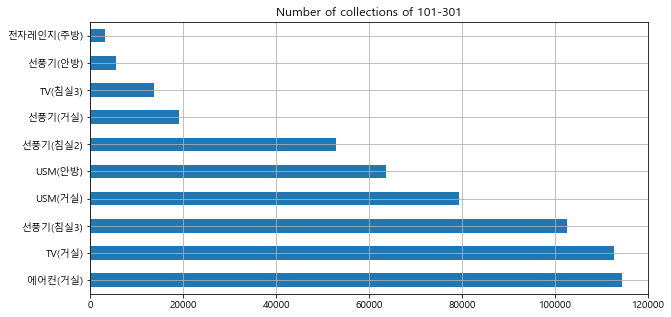

In [85]:
# 수집된 raw data 갯수
plt.figure(figsize=(10,5))
df['name(room)'].value_counts().plot.barh()
plt.title("Number of collections of " + dong + "-" + ho)
plt.grid(True)

In [86]:
resolution = '300S'

# type = CCM
columns = ['name(room)', 'power']
df_device_power =  df[columns]
df_device_power = df_device_power.dropna()
df_device_power = df_device_power.drop_duplicates()
df_device_power = df_device_power.pivot(columns='name(room)', values=['power'])
df_device_power = df_device_power['power']
df_CCM_power = df_device_power.resample(resolution).max()

In [87]:
df_CCM_power.head()

name(room),TV(거실),TV(침실3),선풍기(거실),선풍기(안방),선풍기(침실2),선풍기(침실3),에어컨(거실),전자레인지(주방)
2022-06-15 11:35:00,0.9,0.7,0.5,0.8,0.7,0.9,52.4,0.8
2022-06-15 11:40:00,NaN,NaN,0.9,0.3,0.1,0.0,2.0,0.7
2022-06-15 11:45:00,0.2,0.6,NaN,NaN,NaN,NaN,2.3,NaN
2022-06-15 11:50:00,NaN,NaN,NaN,NaN,0.8,0.8,2.1,NaN
2022-06-15 11:55:00,1.0,NaN,NaN,NaN,0.9,NaN,NaN,NaN


In [71]:
ccm_columns = [i for i in df_CCM_power.columns if "PMM" not in i]

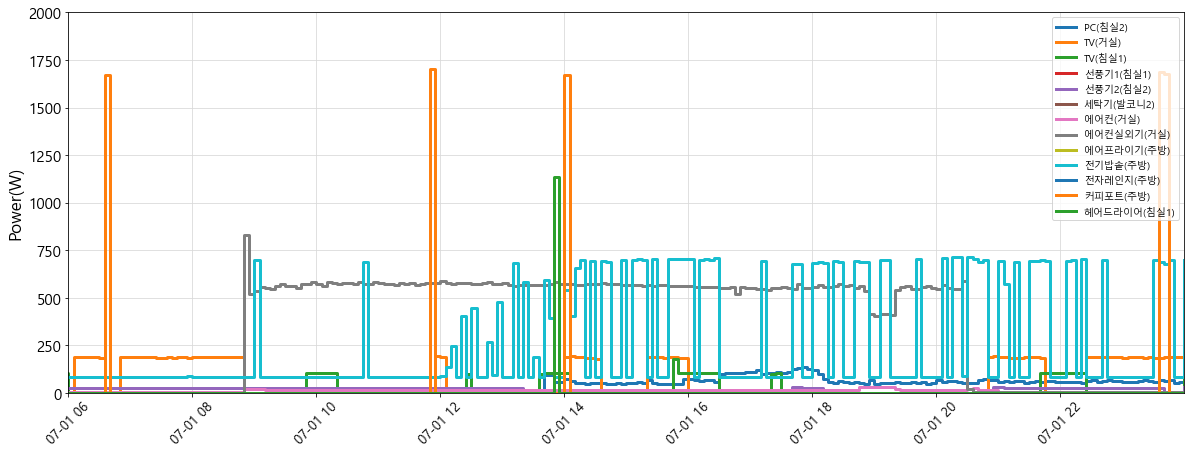

In [72]:
start_time = '2021-07-01 06:00:00'
end_time = '2021-07-01 23:59:59'
plt.figure(figsize=(20, 7))

for ccm in ccm_columns:
    plt.step(df_CCM_power[ccm].index, df_CCM_power[ccm].values, label=ccm, where='post',  linewidth=3)
    
plt.ylim(0, 2000)
plt.xlim(pd.to_datetime(start_time), pd.to_datetime(end_time))
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=15)
plt.ylabel("Power(W)", fontsize=17) #rotation=45)
plt.grid(color='0.85')

plt.legend(loc='upper right', fontsize=10)

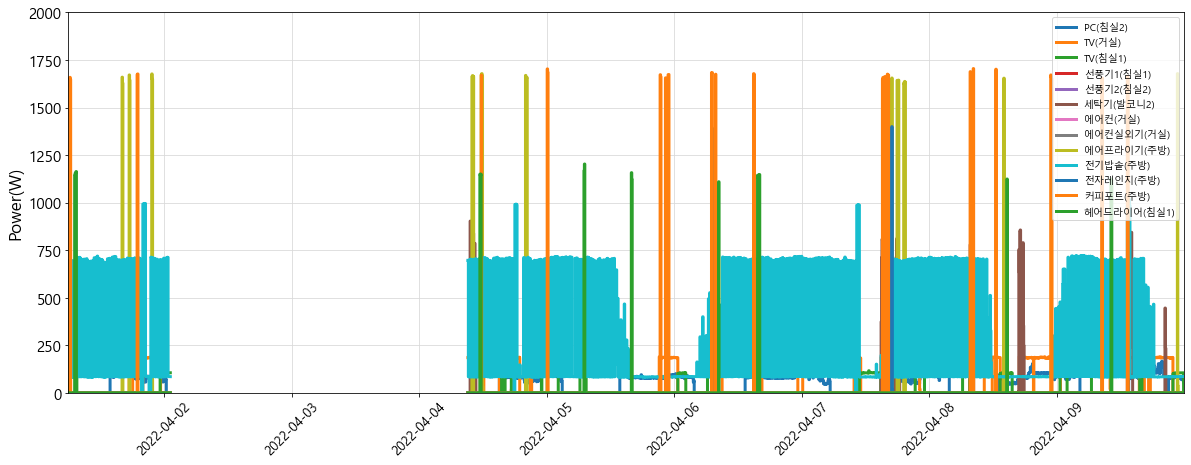

In [73]:
start_time = '2022-04-01 06:00:00'
end_time = '2022-04-09 23:59:59'
plt.figure(figsize=(20, 7))

for ccm in ccm_columns:
    plt.step(df_CCM_power[ccm].index, df_CCM_power[ccm].values, label=ccm, where='post',  linewidth=3)
    
plt.ylim(0, 2000)
plt.xlim(pd.to_datetime(start_time), pd.to_datetime(end_time))
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=15)
plt.ylabel("Power(W)", fontsize=17) # rotation=45)
plt.grid(color='0.85')

plt.legend(loc='upper right', fontsize=10)

### Preprocessing 

- CCM : AC 누적 사용량 및 순시전력
- USM : 재실(거실, 침실1, 침실2, 침실3) -> 공간 어디든 존재한다면 재실 O
- PLC : 가정 부하
- DSM : 도어 센서 (창문)
- AQM : 온도, 습도, CO2 (temperature/ humidity / co2)
- time resolution : 5 min

#### CCM : 순시전력 (실시간 사용량 정의)

In [88]:
resolution = '300S'

# type = CCM
columns = ['name(room)', 'power']
df_device_power =  df[columns]
df_device_power = df_device_power.dropna()
#df_device_power = df_device_power.drop_duplicates()
df_device_power = df_device_power.pivot(columns='name(room)', values=['power'])
df_device_power = df_device_power['power']
df_CCM_power = df_device_power.resample(resolution).max()

In [94]:
df_CCM_power

name(room),TV(거실),TV(침실3),선풍기(거실),선풍기(안방),선풍기(침실2),선풍기(침실3),에어컨(거실),전자레인지(주방)
2022-06-15 11:35:00,0.9,0.7,0.5,0.8,0.7,0.9,52.4,0.8
2022-06-15 11:40:00,0.9,0.5,0.9,0.7,0.7,0.6,2.0,0.7
2022-06-15 11:45:00,0.9,0.6,0.9,0.8,0.7,0.6,2.3,0.6
2022-06-15 11:50:00,0.8,0.5,0.7,0.7,0.8,0.8,2.1,0.7
2022-06-15 11:55:00,1.0,0.7,0.7,0.7,0.9,0.8,2.3,0.8
...,...,...,...,...,...,...,...,...
2022-06-30 23:35:00,121.4,NaN,NaN,NaN,0.6,28.5,2.1,NaN
2022-06-30 23:40:00,120.1,NaN,NaN,NaN,0.7,30.4,2.0,NaN
2022-06-30 23:45:00,120.4,NaN,NaN,NaN,0.7,29.2,2.2,NaN
2022-06-30 23:50:00,120.4,NaN,NaN,NaN,0.7,29.1,2.1,NaN


#### USM : 통합센서 : 재실상태, 온도, 습도, 조도(제외)

- `2021-07-29` ~

In [89]:
df.columns

Index(['deviceId', 'dong', 'ho', 'location', 'power', 'room', 'ts', 'type',
       'current', 'humidity', 'illuminance', 'nickname', 'power-last-day',
       'power-last-month', 'power-this-day', 'power-this-month', 'powerFactor',
       'presence', 'switch', 'temperature', 'voltage', 'name(room)'],
      dtype='object')

In [90]:
#df_usm = df[presence_colums]
usm_columns = ['presence', 'temperature', 'humidity', 'name(room)']
df_usm = df[df['type'] == "USM"][usm_columns].resample(resolution).max().dropna(subset=['name(room)'])

# as-is : 1, 3 -> to-be : 0 (부재)
# as-is : 2, 4 -> to-be : 1 (재실)
df_usm.loc[((df_usm['presence'] == 1) | (df_usm['presence'] == 3)), 'presence'] = 0
df_usm.loc[((df_usm['presence'] == 2) | (df_usm['presence'] == 4)), 'presence'] = 1

# 센서 및 위치를 위한 pivot
df_usm = df_usm.pivot(columns='name(room)', values=['presence', 'humidity', 'temperature'])
df_usm.columns = ["_".join(a) for a in df_usm.columns.to_flat_index()]

In [95]:
df_usm

,presence_USM(거실),presence_USM(안방),humidity_USM(거실),humidity_USM(안방),temperature_USM(거실),temperature_USM(안방)
2022-06-15 11:30:00,1.0,NaN,47.0,NaN,28.5,NaN
2022-06-15 11:35:00,NaN,1.0,NaN,49.0,NaN,29.1
2022-06-15 11:40:00,NaN,1.0,NaN,49.0,NaN,28.9
2022-06-15 11:45:00,1.0,NaN,47.0,NaN,28.4,NaN
2022-06-15 11:50:00,0.0,NaN,47.0,NaN,28.4,NaN
...,...,...,...,...,...,...
2022-06-30 23:35:00,NaN,0.0,NaN,72.0,NaN,29.1
2022-06-30 23:40:00,NaN,0.0,NaN,72.0,NaN,29.1
2022-06-30 23:45:00,NaN,0.0,NaN,72.0,NaN,29.1
2022-06-30 23:50:00,NaN,0.0,NaN,72.0,NaN,29.1


####  AQM : 없는 세대도 존재함

In [91]:
df[df['type'] == "AQM"]

,deviceId,dong,ho,location,power,room,ts,type,current,humidity,...,power-last-day,power-last-month,power-this-day,power-this-month,powerFactor,presence,switch,temperature,voltage,name(room)


#### PLC : 가정 부하

In [92]:
# type = PLC

colums = ['power']
df_PLC = df[df['type'] == 'PLC'][colums]
df_PLC = df_PLC.dropna()
df_PLC = df_PLC.resample(resolution).max()
df_PLC = df_PLC.rename(columns={"power" : "power_this_month"})

In [96]:
df_PLC

,power_this_month
2021-07-01 00:00:00,2978.074
2021-07-01 00:05:00,NaN
2021-07-01 00:10:00,NaN
2021-07-01 00:15:00,2978.251
2021-07-01 00:20:00,NaN
...,...
2022-06-30 23:25:00,NaN
2022-06-30 23:30:00,8314.013
2022-06-30 23:35:00,NaN
2022-06-30 23:40:00,NaN


#### DSM : 도어 센서 (창문)

In [93]:
# type = PLC

df_DSM = df[df['type'] == 'DSM'][['name(room)','door']]
df_DSM = df_DSM.dropna()
df_DSM = df_DSM.drop_duplicates()

# # as-is : 1, 3 -> to-be : 0 (닫힘, 닫힘 지속 감지)
# # as-is : 2, 4 -> to-be : 1 (열림, 열림 지속 감지)
df_DSM.loc[((df_DSM['door'] == 1) | (df_DSM['door'] == 3)), '창문열림상태'] = 0
df_DSM.loc[((df_DSM['door'] == 2) | (df_DSM['door'] == 4)), '창문열림상태'] = 1

df_DSM = df_DSM.pivot(columns='name(room)', values=['창문열림상태'])
df_DSM = df_DSM['창문열림상태']
df_DSM = df_DSM.resample(resolution).min()

df_DSM = df_DSM[['DSM(발코니1)']]
df_DSM = df_DSM.rename(columns={"DSM(발코니1)" : "창문열림(거실)"})

KeyError: "['door'] not in index"

In [97]:
df_DSM

name(room),창문열림(거실)
2021-07-01 00:00:00,1.0
2021-07-01 00:05:00,NaN
2021-07-01 00:10:00,NaN
2021-07-01 00:15:00,NaN
2021-07-01 00:20:00,NaN
...,...
2022-02-04 23:25:00,NaN
2022-02-04 23:30:00,NaN
2022-02-04 23:35:00,NaN
2022-02-04 23:40:00,NaN


#### merge df

In [ ]:
df_temp1 = pd.merge(df_CCM_power, df_usm, left_index=True, right_index=True, how='left')
df_temp2 = pd.merge(df_temp1, df_PLC, left_index=True, right_index=True, how='left')
df_temp3 = pd.merge(df_temp2, df_DSM, left_index=True, right_index=True, how='left')

In [77]:
room_name = '침실3'
room_columns = [i for i in df_temp3.columns if room_name in i]
room_columns

['PC2(침실3)']

KeyError: 'TV(침실1)'

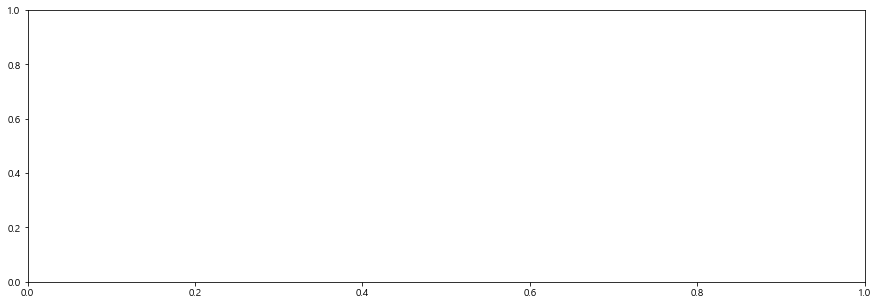

In [21]:
start_time = "2022-04-12 00:00"
end_time = "2022-04-14 23:59"

from matplotlib.ticker import MultipleLocator

# 60 mins 
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

# First Plot
lns1 = ax1.plot(df_temp3[room_columns]['TV(침실1)'].dropna(), 
                color='b', 
                marker = 's', 
                markersize=2, 
                linestyle = "dashed", 
                label='W')


ax1.set_xlim(pd.to_datetime(start_time), pd.to_datetime(end_time))
ax1.set_xlabel('date', fontsize=17)
ax1.set_ylabel('Power (W)', fontsize=17)
ax1.tick_params(axis = 'x', labelsize = 12, rotation=45)
ax1.tick_params(axis = 'y', labelsize = 12)
ax1.grid(linewidth=0.3)

ax1.legend("Power")
ax1.set_title(dong + "-" + ho, fontsize=16, va='bottom', fontweight='semibold')
# ax1.legend(['AC (Wh)'], loc="center right", fontsize=12)

# Second Plot
ax2 = ax1.twinx()

lns2 = ax2.plot(df_temp3[room_columns]['presence_USM(침실1)'], 
                color='black', 
                marker = '*', 
                markersize=2,
                alpha=0.5,
                linestyle = "dashed",
                label='재실유무 (침실1)')

ax2.set_ylim([0, 3])
ax2.set_ylabel('Presence', fontsize=17)
ax2.tick_params(axis = 'y', labelsize = 12)

# added these two lines
lns = lns1+lns2

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best", fontsize=12, bbox_to_anchor=(1.219, 0.5))

plt.tight_layout()
plt.show()

### 가전기기별 색상 지정

- https://wikidocs.net/images/page/92085/set_color_05.PNG

| appliance | character | color | 
| :---: | :---: | :---: |
| TV | 'b' | blue |
| rice cooker | 'g' | green |
| air conditioner | 'limegreen' | limegreen | 
| microwave | 'c' | cyan | 
| air fryer | 'm' | magenta | 
| hair dryer | 'y' | yellow | 
| coffee pot | 'b' | black | 
| washing machine | 'dodgerblue' | dodgerblue | 
| fan | 'bisque' | bisqu | 

In [194]:
TV_colors = ['rosybrown', 'lightcoral', 'indianred', 'brown']
PC_colors = ['goldenrod', 'goldenrod', 'gold', 'khaki']
microwave = ['lighseagreen', 'aqua', 'turquoise', 'lightcyan']
air_fryer = ['yellowgreen', 'chartreuse', 'palegreen', 'lightgreen', 'darkseagreen']
hair_dryer = ['mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet']

In [ ]:
df_temp3.to_csv('new_data/'+dong+"_"+ho+"_appliances(real)_environment(real)_and_houseload(cum).csv")

In [ ]:
df_temp3.columns

In [ ]:
df_temp3

- https://voila-gallery.org/

    - https://hub-binder.mybinder.ovh/user/voila-gallery-e-tymap_dashboard-yuw66sk5/voila/render/Electricity_map.ipynb?token=GN1vxDZ6QlC3WbOUACYdCg

In [199]:
import ipywidgets as widgets

slider = widgets.FloatSlider(description='$x$', value=4)
text = widgets.FloatText(disabled=True, description='$x^2$')

def compute(*ignore):
    text.value = str(slider.value ** 2)

slider.observe(compute, 'value')

widgets.VBox([slider, text])

In [211]:
from ipywidgets import Button, HBox, VBox

words = list(df_temp3.columns)
items = [Button(description=w) for w in words]

left_box = VBox([items[0], items[1]])
middle_box =  VBox([items[2], items[3]])
right_box =  VBox([items[4], items[5]])

HBox([left_box, middle_box, right_box])

In [213]:
ccm_columns

['PC(침실2)',
 'TV(거실)',
 'TV(침실1)',
 '선풍기1(침실1)',
 '선풍기2(침실2)',
 '세탁기(발코니2)',
 '에어컨(거실)',
 '에어컨실외기(거실)',
 '에어프라이기(주방)',
 '전기밥솥(주방)',
 '전자레인지(주방)',
 '커피포트(주방)',
 '헤어드라이어(침실1)']

In [215]:
import numpy as np
import bqplot.pyplot as plt
from bqplot import (
    CATEGORY10,
    ColorScale,
    DateScale,
    LinearScale,
    Lines,
    Axis,
    Figure,
    OrdinalScale,
    Bars,
    Axis,
)


from lib.ENTSOE import fetch_consumption
import pandas as pd
from datetime import datetime, timedelta
import lib
from pkgutil import iter_modules
import importlib
import os
from ipywidgets import (
    TwoByTwoLayout,
    Button,
    Layout,
    jslink,
    IntText,
    IntSlider,
    FloatSlider,
    Dropdown,
)
import json
import random
import requests
from ipyleaflet import Map, GeoJSON, WidgetControl, FullScreenControl, ZoomControl
import ipywidgets as widgets
from ipyflex import FlexLayout

DeprecationWarning: 
            Sentinel is not a public part of the traitlets API.
            It was published by mistake, and may be removed in the future.
            

## csv 데이터 불러오기

In [5]:
dong = '101'
ho = '402'

df_appliance_env = pd.read_csv('new_data/'+dong+"_"+ho+"_appliances(real)_environment(real)_and_houseload(cum).csv",  index_col='Unnamed: 0', infer_datetime_format=True)
df_appliance_env.index = pd.to_datetime(df_appliance_env.index)

### 데이터 시각화

#### 세탁기 사용패턴

In [37]:
import datetime as dt

In [38]:
df_appliance_env.index.weekday

Int64Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', length=105120)

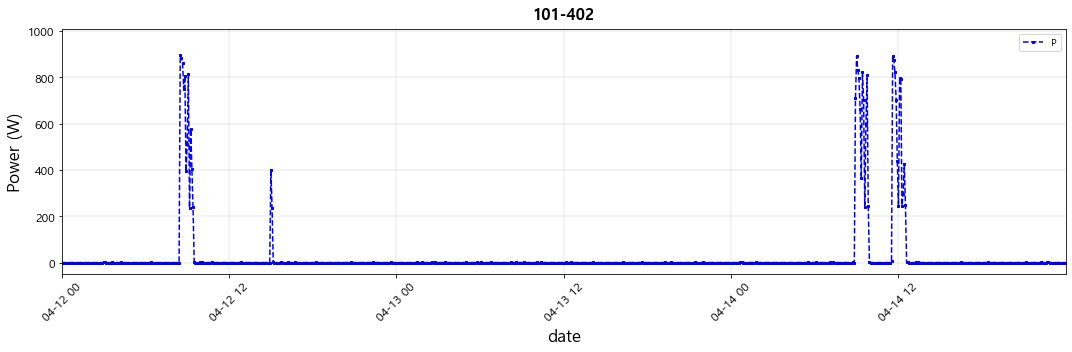

In [15]:

start_time = "2022-04-12 00:00"
end_time = "2022-04-14 23:59"

from matplotlib.ticker import MultipleLocator

# 60 mins 
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

# First Plot
lns1 = ax1.plot(df_appliance_env['세탁기(발코니2)'].dropna(), 
                color='b', 
                marker = 's', 
                markersize=2, 
                linestyle = "dashed", 
                label='W')


ax1.set_xlim(pd.to_datetime(start_time), pd.to_datetime(end_time))
ax1.set_xlabel('date', fontsize=17)
ax1.set_ylabel('Power (W)', fontsize=17)
ax1.tick_params(axis = 'x', labelsize = 12, rotation=45)
ax1.tick_params(axis = 'y', labelsize = 12)
ax1.grid(linewidth=0.3)

ax1.legend("Power")
ax1.set_title(dong + "-" + ho, fontsize=16, va='bottom', fontweight='semibold')
# ax1.legend(['AC (Wh)'], loc="center right", fontsize=12)

# Second Plot
# ax2 = ax1.twinx()

# lns2 = ax2.plot(df_appliance_env['presence_USM(침실1)'], 
#                 color='black', 
#                 marker = '*', 
#                 markersize=2,
#                 alpha=0.5,
#                 linestyle = "dashed",
#                 label='재실유무 (침실1)')

# ax2.set_ylim([0, 3])
# ax2.set_ylabel('Presence', fontsize=17)
# ax2.tick_params(axis = 'y', labelsize = 12)

# # added these two lines
# lns = lns1+lns2

# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc="best", fontsize=12, bbox_to_anchor=(1.219, 0.5))

plt.tight_layout()
plt.show()

In [16]:
df_appliance_env['PC(침실2)']

2021-07-01 00:00:00     52.9
2021-07-01 00:05:00     54.7
2021-07-01 00:10:00     51.1
2021-07-01 00:15:00     57.8
2021-07-01 00:20:00     51.6
                       ...  
2022-06-30 23:35:00    103.9
2022-06-30 23:40:00    103.8
2022-06-30 23:45:00    104.8
2022-06-30 23:50:00    106.1
2022-06-30 23:55:00    103.9
Name: PC(침실2), Length: 105120, dtype: float64